In [50]:
import numpy as np, pandas as pd, os
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sympy 
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.semi_supervised import LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn import svm,linear_model, neural_network
import warnings
from sklearn.svm import NuSVC
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.isotonic import IsotonicRegression
import pickle
from sklearn.linear_model import LinearRegression

In [ ]:
'''
use train_clean everywhere
'''

In [9]:
with open('prediction.pkl', 'rb') as f:
    preds = pickle.load(f)

In [10]:
len(preds)

262144

In [11]:
preds

array([0.80663452, 0.99999825, 0.02839745, ..., 0.99349751, 0.08457693,
       0.94485286])

In [12]:
pred = preds[:131073]

(array([44065.,  7980.,  3753.,  3345.,  1710.,  1650.,  1480.,  1300.,
         1173., 64617.]),
 array([0.0150663 , 0.11355967, 0.21205304, 0.31054641, 0.40903978,
        0.50753315, 0.60602652, 0.70451989, 0.80301326, 0.90150663,
        1.        ]),
 <a list of 10 Patch objects>)

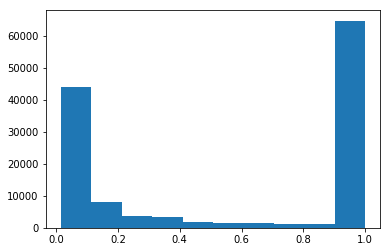

In [13]:
plt.hist(pred)

In [14]:
pred[pred>1].shape

(0,)

In [15]:
pred[pred<0].shape

(0,)

In [16]:
pred[pred<0.1].shape

(41027,)

In [17]:
'''
increase label spreading kfold = 25 before final submission
GM done use 11 kfold for final submission
label encoding done
qda done
NuSvC takes a lot of time. Avoid if possible
'''

'\nincrease label spreading kfold = 25 before final submission\nGM done use 11 kfold for final submission\nlabel encoding done\nqda done\nNuSvC takes a lot of time. Avoid if possible\n'

In [18]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#train = pd.read_csv('../input/train.csv')
#test = pd.read_csv('../input/test.csv')

In [19]:
saved_targets = train['target']

In [20]:
oof_gm = np.zeros(len(train)) 
pred_te_gm = np.zeros(len(test))

oof_svnu = np.zeros(len(train)) 
pred_te_svnu = np.zeros(len(test))

oof_knn = np.zeros(len(train)) 
pred_te_knn = np.zeros(len(test))

oof_mlp = np.zeros(len(train)) 
pred_te_mlp = np.zeros(len(test))

oof_qdp = np.zeros(len(train)) 
pred_te_qdp = np.zeros(len(test))

oof_qlr = np.zeros(len(train)) 
pred_te_qlr = np.zeros(len(test))

oof_outside_blend = np.zeros(len(train)) 
pred_te_outside_blend = np.zeros(len(test))

oof_stack = np.zeros(len(train)) 
pred_te_stack = np.zeros(len(test))

oof_lr = np.zeros(len(train)) 
pred_te_lr = np.zeros(len(test))

oof_ls = np.zeros(len(train)) 
pred_te_ls = np.zeros(len(test))

oof_svc = np.zeros(len(train)) 
pred_te_svc = np.zeros(len(test))

oof_train = np.zeros(len(train)) 
pred_te_test = np.zeros(len(test))

cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic']]

In [21]:
#this is for identifying pseudo labels
for i in tqdm_notebook(range(512)):#range(512):
    if (i==0):
        print("Starting the modelling")
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    
    y = train2.loc[idx1]['target']
    train2.reset_index(drop=True,inplace=True)

    sel = VarianceThreshold(threshold=1.5)
    train3 = sel.fit_transform(train2[cols])  
    test3 = sel.transform(test2[cols])

    # STRATIFIED K-FOLD #reg_param = 0.25 and n_splits = 7 variance threshold = 1.5 so far best
    skf = StratifiedKFold(n_splits=31, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        
        # MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.5)
        clf.fit(train3[train_index,:],train2.loc[train_index]['target'])
        oof_train[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,1]
        pred_te_test[idx2] += clf.predict_proba(test3)[:,1] / skf.n_splits
        
print("ROC for training = ",roc_auc_score(train['target'],oof_train))
print(len(train.loc[abs(train['target']-oof_train)>0.9,'target'])/len(train))

Starting the modelling

ROC for training =  0.9661273000871955
0.050251007080078125


In [22]:
train[(oof_train > 0.2) & (oof_train < 0.8)].shape

(8194, 258)

In [23]:
train.shape

(262144, 258)

In [24]:
train_clean = train[(oof_train <= 0.4 ) | (oof_train >= 0.6)]
train_clean.reset_index(drop=True,inplace=True)

In [25]:
train_clean.shape

(255696, 258)

In [26]:
from sklearn.covariance import GraphicalLasso

def get_mean_cov(x,y):
    model = GraphicalLasso()
    ones = (y==1).astype(bool)
    x2 = x[ones]
    model.fit(x2)
    p1 = model.precision_
    m1 = model.location_
    
    onesb = (y==0).astype(bool)
    x2b = x[onesb]
    model.fit(x2b)
    p2 = model.precision_
    m2 = model.location_
    
    ms = np.stack([m1,m2])
    ps = np.stack([p1,p2])
    return ms,ps

In [30]:
#GaussianMixture this is without pseudo labeling
# BUILD 512 SEPARATE MODELS
saved_targets = train_clean['target']
test["target"] = pred
oof_gm = np.zeros(len(train_clean)) 
pred_te_gm = np.zeros(len(test))
for i in tqdm_notebook(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train_clean[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    # STRATIFIED K-FOLD
    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3, train2['target']):
        #test_index3 = test_index[ test_index<len(train2)] # ignore psuedo in oof
        # MODEL AND PREDICT WITH QDA
        ms, ps= get_mean_cov(train3[train_index,:],train2.loc[train_index]['target'].values)      
        clf = GaussianMixture(n_components=2, init_params='random', covariance_type='full', tol=0.0001,reg_covar=0.001, max_iter=100, n_init=1,means_init=ms, precisions_init=ps,verbose=False)
        clf.fit(np.concatenate([train3[train_index,:],test3],axis = 0))
        oof_gm[idx1[test_index]] = clf.predict_proba(train3[test_index,:])[:,0]
        pred_te_gm[idx2] += clf.predict_proba(test3)[:,0] / skf.n_splits

KeyboardInterrupt: 

In [31]:
auc = roc_auc_score(saved_targets,oof_gm)
print('Pseudo Labeled GM scores CV =',round(auc,8)) 

Pseudo Labeled GM scores CV = 0.50418269


In [32]:
#QDA this is with pseudo labeling
# BUILD 512 SEPARATE MODELS
saved_targets = train_clean['target']
test["target"] = pred
oof_qdp = np.zeros(len(train_clean)) 
pred_te_qdp = np.zeros(len(test))
for k in tqdm_notebook(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train_1 = train[train['wheezy-copper-turtle-magic']==k] 
    train2 = train_clean[train_clean['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    #train_1.reset_index(drop=True,inplace=True)
    # ADD PSEUDO LABEL DATA
    test2p = test2[ (test2['target']<=0.2) | (test2['target']>=0.9) ].copy()#.9999 and 0.0001 gives 0.97046394
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=31, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train2)] # ignore psuedo in oof
        #print()
        #MODEL AND PREDICT WITH QDA
        clf = QuadraticDiscriminantAnalysis(reg_param=0.45) #best 0.8  0.96955481 0.3 0.96992156 0.11 0.96988311 0.5 0.96993603 0.55 0.9699333 0.45 0.96994102 0.4 0.96993985
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof_qdp[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        pred_te_qdp[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits

In [33]:
auc = roc_auc_score(saved_targets,oof_qdp)
print('Pseudo Labeled QDA scores CV =',round(auc,8)) 

Pseudo Labeled QDA scores CV = 0.96983357


In [34]:
#MLP this is with pseudo labeling
# BUILD 512 SEPARATE MODELS
saved_targets = train_clean['target']
test["target"] = pred
oof_mlp = np.zeros(len(train_clean)) 
pred_te_mlp = np.zeros(len(test))
for k in tqdm_notebook(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train_clean[train_clean['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    #train_1.reset_index(drop=True,inplace=True)
    # ADD PSEUDO LABEL DATA
    test2p = test2[ (test2['target']<=0.2) | (test2['target']>=0.9) ].copy()#.9999 and 0.0001 gives 0.97046394
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train2)] # ignore psuedo in oof
        #print()
        #MODEL AND PREDICT WITH QDA
        clf = neural_network.MLPClassifier(solver='lbfgs',tol=1e-6,hidden_layer_sizes=(54,),random_state=42)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof_mlp[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        pred_te_mlp[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits

In [35]:
auc = roc_auc_score(saved_targets,oof_mlp)
print('Pseudo Labeled MLP scores CV =',round(auc,8)) 

Pseudo Labeled MLP scores CV = 0.92219186


In [45]:
#QLR
# BUILD 512 SEPARATE MODELS
saved_targets = train_clean['target']
test["target"] = pred
oof_qlr = np.zeros(len(train_clean)) 
pred_te_qlr = np.zeros(len(test))
for k in tqdm_notebook(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train_clean[train_clean['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    #train_1.reset_index(drop=True,inplace=True)
    # ADD PSEUDO LABEL DATA
    test2p = test2[ (test2['target']<=0.2) | (test2['target']>=0.9) ].copy()#.9999 and 0.0001 gives 0.97046394
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2p[cols])     
    train3p = sel.transform(train2p[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])
    
    #Quadriatic Linear regression
    poly = PolynomialFeatures(degree=2).fit(train3p)
    train3p = poly.transform(train3p)
    train3 = poly.fit_transform(train3)
    test3 = poly.transform(test3)
   
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train2)] # ignore psuedo in oof
        #print()
        #MODEL AND PREDICT WITH QDA
        clf = LogisticRegression(solver='lbfgs',penalty='l2',C=0.0001,tol=0.0001)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof_qlr[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        pred_te_qlr[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits

In [46]:
auc = roc_auc_score(saved_targets,oof_qlr)
print('Pseudo Labeled QLR scores CV =',round(auc,8)) 

Pseudo Labeled QLR scores CV = 0.95293564


In [47]:
#NuSVM
#MLP this is with pseudo labeling
# BUILD 512 SEPARATE MODELS
saved_targets = train_clean['target']
test["target"] = pred
oof_svnu = np.zeros(len(train_clean)) 
pred_te_svnu = np.zeros(len(test))
for k in tqdm_notebook(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train_clean[train_clean['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    #train_1.reset_index(drop=True,inplace=True)
    # ADD PSEUDO LABEL DATA
    test2p = test2[ (test2['target']<=0.2) | (test2['target']>=0.9) ].copy()#.9999 and 0.0001 gives 0.97046394
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    pca = PCA(svd_solver='full',n_components='mle')
    train3p = pca.fit_transform(train2p[cols])
    train3 = pca.transform(train2[cols])
    test3 = pca.transform(test2[cols])
    
    scale = StandardScaler()
    train3p = scale.fit_transform(train3p)
    train3 = scale.transform(train3)
    test3 =  scale.transform(test3)
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train2)] # ignore psuedo in oof
        #print()
        #MODEL AND PREDICT WITH QDA
        clf = NuSVC(.5,'poly',4,'auto',0.05,0,1,0.00001)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof_svnu[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        pred_te_svnu[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits

KeyboardInterrupt: 

In [ ]:
auc = roc_auc_score(saved_targets,oof_svnu)
print('Pseudo Labeled SVNU scores CV =',round(auc,8)) 

In [ ]:
#SVC
#MLP this is with pseudo labeling
# BUILD 512 SEPARATE MODELS
saved_targets = train_clean['target']
test["target"] = pred
oof_svc = np.zeros(len(train_clean)) 
pred_te_svc = np.zeros(len(test))
for k in tqdm_notebook(range(512)):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train_clean[train_clean['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    #train_1.reset_index(drop=True,inplace=True)
    # ADD PSEUDO LABEL DATA
    test2p = test2[ (test2['target']<=0.2) | (test2['target']>=0.9) ].copy()#.9999 and 0.0001 gives 0.97046394
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    pca = PCA(svd_solver='full',n_components='mle')
    train3p = pca.fit_transform(train2p[cols])
    train3 = pca.transform(train2[cols])
    test3 = pca.transform(test2[cols])
    
    scale = StandardScaler()
    train3p = scale.fit_transform(train3p)
    train3 = scale.transform(train3)
    test3 =  scale.transform(test3)
        
    # STRATIFIED K FOLD
    skf = StratifiedKFold(n_splits=11, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train3p, train2p['target']):
        test_index3 = test_index[ test_index<len(train2)] # ignore psuedo in oof
        #print()
        #MODEL AND PREDICT WITH QDA
        clf = svm.SVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=42)
        clf.fit(train3p[train_index,:],train2p.loc[train_index]['target'])
        oof_svc[idx1[test_index3]] = clf.predict_proba(train3[test_index3,:])[:,1]
        pred_te_svc[test2.index] += clf.predict_proba(test3)[:,1] / skf.n_splits

In [ ]:
auc = roc_auc_score(saved_targets,oof_svc)
print('Pseudo Labeled SVNU scores CV =',round(auc,8)) 

In [41]:
#LabelSpreading
# BUILD 512 SEPARATE MODELS
saved_targets = train_clean['target']
test["target"] = pred
oof_ls = np.zeros(len(train_clean)) 
pred_te_ls = np.zeros(len(test))
for k in tqdm_notebook(range(512)):
    train2 = train_clean[train_clean['wheezy-copper-turtle-magic']==k] 
    train2p = train2.copy(); idx1 = train2.index 
    test2 = test[test['wheezy-copper-turtle-magic']==k]
    
    test2p = test2[ (test2['target']<=0.2) | (test2['target']>=0.9) ].copy()
    test2p.loc[ test2p['target']>=0.5, 'target' ] = 1
    test2p.loc[ test2p['target']<0.5, 'target' ] = 0 
    train2p = pd.concat([train2p,test2p],axis=0)
    train2p.reset_index(drop=True,inplace=True)
    
    test2["target"] = -1
    #merging train2p with full test
    train3p = pd.concat([train2p,test2],axis=0)
    train3p.reset_index(drop=True,inplace=True)

    sel = VarianceThreshold(threshold=1.5).fit(train3p[cols])     
    train4p = sel.transform(train3p[cols])
    train4 = sel.transform(train2[cols])
    test4 = sel.transform(test2[cols])
    
    skf = StratifiedKFold(n_splits=25, random_state=42, shuffle=True)
    for train_index, test_index in skf.split(train4p, train3p['target']):
        test_index3 = test_index[ test_index<len(train4) ]        
        clf = LabelSpreading(gamma=0.01,kernel='rbf', max_iter=10)
        clf.fit(train4p[train_index,:],train3p.loc[train_index]['target'])
        oof_ls[idx1[test_index3]] = clf.predict_proba(train4[test_index3,:])[:,1]
        pred_te_ls[test2.index] += clf.predict_proba(test4)[:,1] / skf.n_splits
auc = roc_auc_score(saved_targets,oof_ls)
print('CV for LabelSpreading =',round(auc,8)) 

CV for LabelSpreading = 0.94360835


In [ ]:
# PRINT CV AUC GM
auc = roc_auc_score(saved_targets,oof_gm)
print('GaussianMixture scores CV =',round(auc,8))

# PRINT CV QDP
oof = oof_qdp
oof_scaled = (oof-np.amin(oof))/(np.amax(oof)-np.amin(oof))
auc = roc_auc_score(saved_targets,oof_qdp)
print('Pseudo Labeled QDA scores CV =',round(auc,8)) 

auc = roc_auc_score(saved_targets,oof_ls)
print('CV for LabelSpreading =',round(auc,8)) 

auc = roc_auc_score(saved_targets,oof_svnu)
print('CV for SVNU =',round(auc,8)) 

In [51]:
#BLENDING
#oof outside blend
y = train_clean['target']
X = []
X.append(oof_gm.reshape(1,-1)[0])
X.append(oof_qdp.reshape(1,-1)[0])
X.append(oof_mlp.reshape(1,-1)[0])
X.append(oof_qlr.reshape(1,-1)[0])
X.append(oof_svnu.reshape(1,-1)[0])
X.append(oof_svc.reshape(1,-1)[0])
X.append(oof_ls.reshape(1,-1)[0])
X = pd.DataFrame(X).transpose().copy()
mdl = LinearRegression()
mdl.fit(X,y) 
print("mdl score = ",mdl.score(X,y))

gm_coef = round(mdl.coef_[0]/sum(mdl.coef_),5)
qdp_coef = round(mdl.coef_[1]/sum(mdl.coef_),5)
mlp_coef = round(mdl.coef_[2]/sum(mdl.coef_),5)
qlr_coef = round(mdl.coef_[3]/sum(mdl.coef_),5)
svnu_coef = round(mdl.coef_[4]/sum(mdl.coef_),5)  
svc_coef = round(mdl.coef_[5]/sum(mdl.coef_),5)  
ls_coef = round(mdl.coef_[6]/sum(mdl.coef_),5)  

print("gm Coeff = {} qdp Coeff = {} mlp Coeff = {} qlr Coeff = {} svnu Coeff = {} svc Coeff = {} ls Coeff = {}"
      .format(gm_coef,qdp_coef,mlp_coef,qlr_coef,svnu_coef,svc_coef,ls_coef))

oof_outside_blend = oof_gm*gm_coef + oof_qdp*qdp_coef + oof_mlp*mlp_coef + oof_qlr*qlr_coef + oof_svnu*svnu_coef + oof_svc*svc_coef + oof_ls*ls_coef

pred_te_outside_blend = pred_te_gm*gm_coef + pred_te_qdp*qdp_coef + pred_te_mlp*mlp_coef + pred_te_qlr*qlr_coef + pred_te_svnu*svnu_coef + pred_te_svc*svc_coef + pred_te_ls*ls_coef

mdl score =  0.8060553128998684
gm Coeff = 0.00431 qdp Coeff = 0.71607 mlp Coeff = 0.02538 qlr Coeff = 0.06687 svnu Coeff = 0.02587 svc Coeff = 0.0 ls Coeff = 0.16149


In [56]:
#STACKING
oof_stack_lgb = np.zeros(len(train_clean))
pred_te_stack_lgb = np.zeros(len(test))

oof_gm = oof_gm.reshape(-1, 1)
pred_te_gm = pred_te_gm.reshape(-1, 1)
oof_qdp = oof_qdp.reshape(-1, 1)
pred_te_qdp = pred_te_qdp.reshape(-1, 1)
oof_mlp = oof_mlp.reshape(-1, 1)
pred_te_mlp = pred_te_mlp.reshape(-1, 1)
oof_qlr = oof_qlr.reshape(-1, 1)
pred_te_qlr = pred_te_qlr.reshape(-1, 1)
oof_svnu = oof_svnu.reshape(-1, 1)
pred_te_svnu = pred_te_svnu.reshape(-1, 1)
oof_svc = oof_svc.reshape(-1, 1)
pred_te_svc = pred_te_svc.reshape(-1, 1)
oof_ls = oof_ls.reshape(-1, 1)
pred_te_ls = pred_te_ls.reshape(-1, 1)

tr = np.concatenate((oof_gm, oof_qdp, oof_mlp,oof_qlr,oof_svnu,oof_svc,oof_ls), axis=1)
te = np.concatenate((pred_te_gm, pred_te_qdp, pred_te_mlp,pred_te_qlr,pred_te_svnu,pred_te_svc,pred_te_ls), axis=1)
print(tr.shape, te.shape)

#scale = StandardScaler()
#tr = scale.fit_transform(tr)
#te = scale.transform(te)

skf = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skf.split(tr,train_clean['target']):
    lrr = linear_model.LogisticRegression(solver='lbfgs') # solver='liblinear',penalty='l1',C=0.1
    lrr.fit(tr[train_index],train_clean['target'][train_index])
    oof_stack[test_index] = lrr.predict_proba(tr[test_index,:])[:,1]
    pred_te_stack += lrr.predict_proba(te)[:,1] / skf.n_splits
    
    model = lgb.LGBMClassifier(objective = 'binary',min_data_in_leaf=5,n_jobs=-1,metric='auc',learning_rate=0.1,num_leaves=15,
                              feature_fraction=1.0,lambda_l1=15,min_sum_hessian_in_leaf=7)
    model.fit(tr[train_index],train_clean['target'][train_index])
    oof_stack_lgb[test_index] = model.predict_proba(tr[test_index,:])[:,1]
    pred_te_stack_lgb += model.predict_proba(te)[:,1] / skf.n_splits

iso = IsotonicRegression(y_min=0, y_max=1,out_of_bounds='clip')
iso.fit(oof_stack_lgb,train_clean['target'].values)
isooof = iso.transform(oof_stack_lgb)
isopreds = iso.transform(pred_te_stack_lgb)

(255696, 7) (131073, 7)


In [ ]:
pd.DataFrame(isopreds).describe()

In [ ]:
auc = roc_auc_score(saved_targets,oof_stack)
print('CV for LR Stacking =',round(auc,8)) 

auc = roc_auc_score(saved_targets,oof_stack_lgb)
print('CV for LR Stacking LGB =',round(auc,8)) 

auc = roc_auc_score(saved_targets,isooof)
print('CV for ISO Preds =',round(auc,8)) 

In [ ]:
auc = roc_auc_score(saved_targets,oof_stack)
print('CV for LR Stacking =',round(auc,8)) 

auc = roc_auc_score(saved_targets,oof_stack_lgb)
print('CV for LR Stacking =',round(auc,8))  0.97189459

In [ ]:
'''
default QDA scores CV = 0.96878
QDA scores CV = 0.96814
0.9677
'''